In [1]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image, ImageOps
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

/home/phdomingues/.miniconda3/envs/sam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MASKS_PATH = Path(r'/home/phdomingues/masters/data/datasets/Occlusion/masks')
IMAGE_PATH = Path(r'/home/phdomingues/masters/data/images/f6.jpg')

#img = Image.open('/home/phdomingues/experiments/data/Datasets/UNIFESP/sem_dor/30_161338.bmp').convert('RGB')
#img = Image.open('/home/phdomingues/experiments/data/Datasets/ICope/com_dor/i5.jpeg').convert('RGB')
img = Image.open(IMAGE_PATH).convert('RGB')

img = ImageOps.exif_transpose(img)


In [3]:
# model = ViTForImageClassification.from_pretrained('/home/phdomingues/experiments/data/Results/Exp3-Transformers/UNIFESP/UNIFESP/lr00002/k1/best', output_attentions=True)
model = ViTForImageClassification.from_pretrained('/home/phdomingues/masters/results/classification_models/ViT/UNIFESP360Faces', output_attentions=True)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [4]:
def process_images_vit(img_path, mask_path, model, processor):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    
    mask_img = cv2.imread(str(mask_path), 0)
    if mask_img is None:
        print(f'ViT: mask {mask_path.name} not found... skipping')
        return

    # img = cv2.bitwise_and(img, img, mask=mask_img)

    rows, cols = np.where(mask_img>0)
    img = img[min(rows):max(rows), min(cols):max(cols)]
    
    inputs = processor(images=img, return_tensors="pt") # pt = torch.tensor

    return Image.fromarray(img), model(**inputs)

In [5]:
# IMAGES_PATH = Path(r'/home/phdomingues/masters/data/datasets/Occlusion/images')
# MASKS_PATH = Path(r'/home/phdomingues/masters/data/datasets/Occlusion/masks')

# # IMAGES_PATH = Path(r'/home/phdomingues/masters/data/UNIFESP/all')
# # MASKS_PATH = Path(r'/home/phdomingues/masters/data/datasets/UNIFESP360/masks')

# i = 0
# img_paths = sorted(list(IMAGES_PATH.glob('*')), key=lambda a: int(a.stem[1:]))[:-1]
# img_paths = [p for p in img_paths if p.stem in ('f4', 'f5', 'f6')]
# fig, axs = plt.subplots(nrows=len(img_paths), ncols=3, figsize=(10, 3.7*len(img_paths)))
# ax1, ax2, ax3 = axs[0]
# ax1.set_title('Original')
# ax2.set_title('Attention Map Last Layer')
# ax3.set_title('Attention Map Overlay')

# for i, image_path in enumerate(img_paths):    
#     mask_path = MASKS_PATH/image_path.with_suffix('.png').name
#     img, result = process_images_vit(image_path, mask_path, model, processor)

#     predicted_class_idx = result.logits.argmax(-1).item()
#     predicted_class = model.config.id2label[predicted_class_idx]

#     att_mat = torch.stack(result.attentions).squeeze(1)

#     # Average the attention weights across all heads.
#     att_mat = torch.mean(att_mat, dim=1)
#     #att_mat = att_mat[1]

#     # To account for residual connections, we add an identity matrix to the
#     # attention matrix and re-normalize the weights
#     residual_att = torch.eye(att_mat.size(1))
#     aug_att_mat = att_mat + residual_att
#     aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

#     # Recursively multiply the weight matrices
#     joint_attentions = torch.zeros(aug_att_mat.size())
#     joint_attentions[0] = aug_att_mat[0]

#     for n in range(1, aug_att_mat.size(0)):
#         joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

#     v = joint_attentions[0]
#     grid_size = int(np.sqrt(aug_att_mat.size(-1)))

#     mask1 = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
#     result1 = cv2.resize(mask1 / mask1.max(), img.size)

#     mask2 = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
#     mask2 = cv2.resize(mask2 / mask2.max(), img.size)[..., np.newaxis]
#     result2 = (mask2 * img).astype("uint8")

#     ax1, ax2, ax3 = axs[i]
#     # fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 5))
#     # fig.suptitle(f'{image_path.name} - Predicted class: {predicted_class.replace("_", " ")}')
#     # ax1.set_title('Original')
#     # ax2.set_title('Attention Map Last Layer')
#     # ax3.set_title('Attention Map Overlay')
#     ax1.set_axis_off()
#     ax2.set_axis_off()
#     ax3.set_axis_off()
#     _ = ax1.imshow(img)
#     _ = ax2.imshow(result1)
#     _ = ax3.imshow(result2)

#     if i > 5:
#         continue
#         # break
#     else:
#         i+=1

# plt.subplots_adjust(wspace=0.05, hspace=0)
# plt.show()
#     # f1, f4, f5

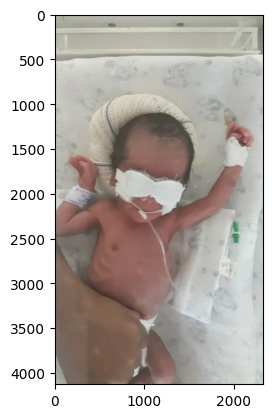

In [6]:
plt.imshow(img)

In [7]:
mask_path = MASKS_PATH/IMAGE_PATH.with_suffix('.png').name
img, result = process_images_vit(IMAGE_PATH, mask_path, model, processor)

inputs = processor(img, return_tensors='pt')
outputs = model(inputs['pixel_values'])

predicted_class_idx = outputs.logits.argmax(-1).item()
predicted_class = model.config.id2label[predicted_class_idx]

In [8]:
inputs

{'pixel_values': tensor([[[[-0.1294, -0.1059, -0.1216,  ..., -0.3412, -0.3020, -0.2706],
          [-0.1686, -0.1294, -0.1216,  ..., -0.3569, -0.3333, -0.3333],
          [-0.1843, -0.1686, -0.1608,  ..., -0.3725, -0.3647, -0.3490],
          ...,
          [ 0.1529,  0.1529,  0.1608,  ...,  0.2157,  0.2157,  0.2000],
          [ 0.1686,  0.1686,  0.1686,  ...,  0.2157,  0.2157,  0.2078],
          [ 0.1686,  0.1608,  0.1529,  ...,  0.2235,  0.2314,  0.2157]],

         [[-0.1843, -0.1608, -0.1765,  ..., -0.3647, -0.3255, -0.3098],
          [-0.2235, -0.1843, -0.1765,  ..., -0.3804, -0.3569, -0.3569],
          [-0.2314, -0.2078, -0.2000,  ..., -0.3961, -0.3882, -0.3725],
          ...,
          [-0.2549, -0.2549, -0.2471,  ..., -0.1373, -0.1373, -0.1529],
          [-0.2392, -0.2392, -0.2392,  ..., -0.1373, -0.1373, -0.1451],
          [-0.2392, -0.2471, -0.2549,  ..., -0.1216, -0.1137, -0.1294]],

         [[-0.2392, -0.2078, -0.2235,  ..., -0.4353, -0.3804, -0.3569],
          [-0

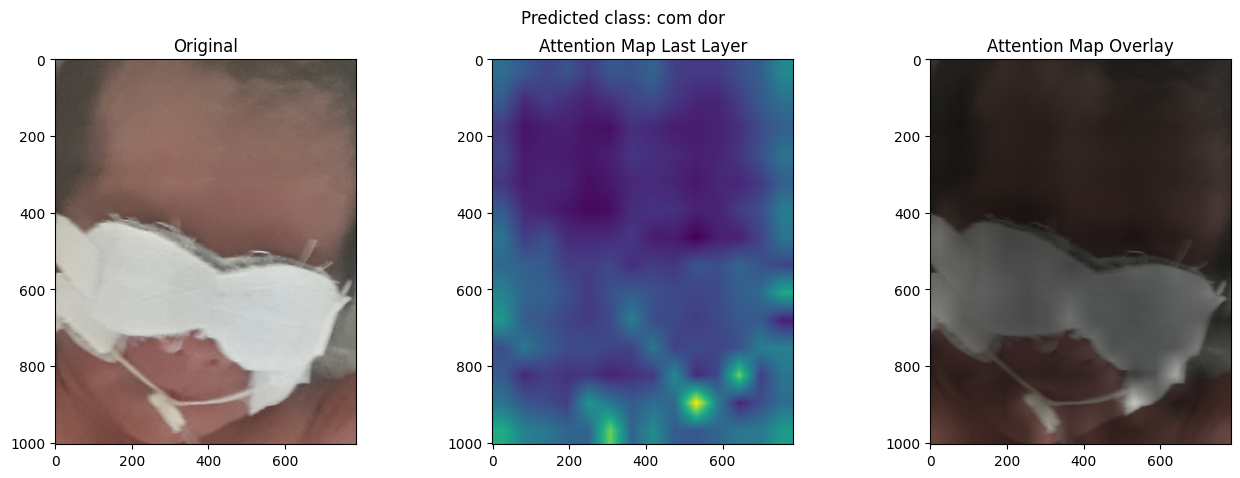

In [9]:
att_mat = torch.stack([outputs.attentions[0]]).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))

mask1 = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
result1 = cv2.resize(mask1 / mask1.max(), img.size)

mask2 = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask2 = cv2.resize(mask2 / mask2.max(), img.size)[..., np.newaxis]
result2 = (mask2 * img).astype("uint8")

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 5))
fig.suptitle(f'Predicted class: {predicted_class.replace("_", " ")}')
ax1.set_title('Original')
ax2.set_title('Attention Map Last Layer')
ax3.set_title('Attention Map Overlay')
_ = ax1.imshow(img)
_ = ax2.imshow(result1)
_ = ax3.imshow(result2)

In [10]:
mask1[0][0]

0.001149165

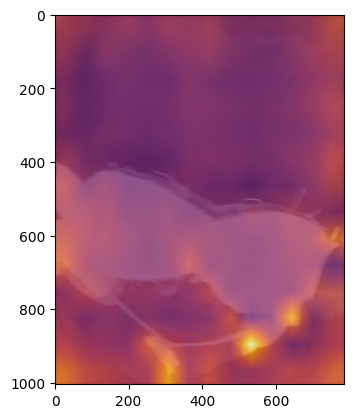

In [11]:
colormap = plt.get_cmap('inferno')
heatmap = (colormap(result1) * 255).astype(np.uint8)[:,:,:3]
plt.imshow(cv2.addWeighted(np.array(img),0.3,heatmap,0.7,0))